# 2. Bag of Words Meets Bags of Popcorn : Word2Vec

## Table of Contents

1. [Introduction](#intro)<br><br>
2. [Reading the Data](#reading)<br><br>
3. [Data Cleaning and Text Preprocessing](#dctp)<br> - [3.1. Splitting a Sentence to Words](#ssw)<br> - [3.2. Splitting a Paragraph to Sentences](#sps)<br> - [3.3. Combining Labeled and Unlabeled Reviews](#clur)<br><br>
4. [Word2Vec](#word2vec)<br><br>
5. [Visualization](#viz)<br><br>
6. [From Words to Paragraph](#fwp)<br> - [6.1. Vector Averaging](#vaveraging)<br> - [6.2. Clustering](#clustering)<br> - [6.2.1 KMeans Clustering](#kmc)<br> - [6.2.2. Mapping Vocabulary to Cluster](#mvc)<br> - [6.2.3. Bag of Centroids](#boc)<br><br>
7. [Modeling](#modeling)<br>- [7.1. Modeling for Vector Averaging](#mva)<br> - [7.1.1. Linear Support Vector Machine](#svm1)<br>- [7.1.2. Bernoulli Naive Bayes Classifier](#bnb1)<br>- [7.1.3. Perceptron](#perceptron1)<br> - [7.1.4. Logistic Regression](#logi1)<br> - [7.2. Modeling for Clustering](#mc)<br> - [7.2.1. Linear Support Vector Machine](#svm2)<br> - [7.2.2. Bernoulli Naive Bayes Classifier](#bnb2)<br> - [7.2.3. Perceptron](#perceptron2)<br> - [7.2.4. Logistic Regression](#logi2)<br><br>
8. [Submission](#submission)<br><br>
9. [Conclusion](#conclusion)<br><br>

First notebook: [Bag of Words Meets Bags of Popcorn: CountVectorizer](https://www.kaggle.com/kyen89/0-sentiment-analysis-countvectorizer/)<br>
Second notebook: [Bag of Words Meets Bags of Popcorn: TF-IDF](https://www.kaggle.com/kyen89/1-sentiment-analysis-tf-idf)

## 1. Introduction <a id = "intro"></a>

This is the third notebook for IMDb sentiment analysis (First notebook: [Bag of Words Meets Bags of Popcorn: CountVectorizer](url_here), Second notebook: [Bag of Words Meets Bags of Popcorn: TF-IDF](url_here)). In this notebook, for a bit deeper sentiment analysis, we will be using Word2Vec to train a model. Word2Vec is a neural network based algorithm that creates distributed word vectors.
One of the advantages of Word2Vec over Bag Of Words, it understands meaning and semantic relationships among words. Also, it does not require labels in order to create meaningful representations. In addition that in a aspect of speed, it learns quickly compared to other methods. Once the Word2Vec is created, we will visualize the vectorized data by t-SNE. Before we dive into modeling, there is one more step to prepare two different matrices created by using Word2Vec by vector averaging method and clustering method. We will test them independently and choose the best one among the results predicted by different methods including 'bag of words' and 'TF-IDF.

## 2. Reading the Data <a id = "reading"></a>

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read the labeled training and test data
# Header = 0 indicates that the first line of the file contains column names, 
# delimiter = \t indicates that the fields are seperated by tabs, and 
# quoting = 3 tells python to ignore doubled quotes

train = pd.read_csv('labeledTrainData.tsv', header = 0, delimiter = '\t', quoting = 3)
test = pd.read_csv('testData.tsv', header = 0, delimiter = '\t', quoting = 3)
unlabel_train = pd.read_csv('unlabeledTrainData.tsv', header = 0, delimiter = '\t', quoting = 3)

In [3]:
'train dim:{}, unlabeled train dim:{}, test dim:{}'.format(train.shape, unlabel_train.shape, test.shape)

'train dim:(25000, 3), unlabeled train dim:(50000, 2), test dim:(25000, 2)'

One thing to notice is that unlike the previous two notebook, now we can use a unlabeled data set since as mentioned to the introduction, word2vec can learn from unlabeled data.

## 3. Data Cleaning and Text Preprocessing <a id='dctp'></a>


In [4]:
# Import the libraries for data cleaning.

from bs4 import BeautifulSoup
import re
import nltk

### 3.1 Splitting a Sentence to Words <a id='ssw'></a>

In [5]:
def preprocess_wordlist(data, stopwords = False):
    
    # Remove HTML tag
    review = BeautifulSoup(data,'html.parser').get_text()
    
    # Remove non-letters
    review = re.sub('[^a-zA-Z]', ' ', review)
    
    # Convert to lower case
    review = review.lower()
    
    # Tokenize
    word = nltk.word_tokenize(review)
    
    # Optional: Remove stop words (false by default)
    if stopwords:
        stops = set(nltk.corpus.stopwords.words("english"))
        
        words = [w for w in word if not w in stops]
    
    return word


For creating a model, unlike Bag Of Words method, it is not necessary to remove the stopwords such as "the", "a", "and", etc as the algorithm relies on the broader context of the sentence in order to produce high-quality word vectors. Another thing to mention is that it may improve the accuracy to keep numbers from the data but for the simplicity, I decide to delete everything except alphabet characters.

### 3.2 Splitting a Paragraph to Sentences <a id='sps'></a>

In [6]:
def preprocess_sent(data, stopwords = False):
    
    # Split the paragraph into sentences
    
    #raw = tokenizer.tokenize(data.strip())
    raw = nltk.sent_tokenize(data.strip())
    
    # If the length of the sentence is greater than 0, plug the sentence in the function preprocess_wordlist (clean the sentence)
    sentences = [preprocess_wordlist(sent, stopwords) for sent in raw if len(sent) > 0]
    
    return sentences

The most important thing to notice is splitting sentences by sentences __prior to__ splitting them to single word because you will lose the information which words have formed a sentence if you split into words first. Some may question that simple split function might be enough to split up a paragraph to sentences; however, English sentences can end with many punctuations and it is not strange that anything can be placed at the end of the sentences. For this reason, when we split text into sentences, we need to use NLTK's punkt tokenizer (sent_tokenize function uses an instance of a punkt tokenizer). The punkt tokenizer is an unsupervised trainable model ,which enables that the tokenizer uses to decide where to cut or learn abbreviations in text.

### 3.3 Combining Labeled and Unlabeled Reviews <a id='clur'></a>

In [7]:
sentence = []

# Append labeled reviews first
for review in train['review']:
    sentence += preprocess_sent(review)
    
# Append unlabeled reviews
for review in unlabel_train['review']:
    sentence += preprocess_sent(review)


In [8]:
print(len(sentence))
print()
print(sentence[:2])

795538

[['with', 'all', 'this', 'stuff', 'going', 'down', 'at', 'the', 'moment', 'with', 'mj', 'i', 've', 'started', 'listening', 'to', 'his', 'music', 'watching', 'the', 'odd', 'documentary', 'here', 'and', 'there', 'watched', 'the', 'wiz', 'and', 'watched', 'moonwalker', 'again'], ['maybe', 'i', 'just', 'want', 'to', 'get', 'a', 'certain', 'insight', 'into', 'this', 'guy', 'who', 'i', 'thought', 'was', 'really', 'cool', 'in', 'the', 'eighties', 'just', 'to', 'maybe', 'make', 'up', 'my', 'mind', 'whether', 'he', 'is', 'guilty', 'or', 'innocent']]


In [9]:
train['review'][0]

'"With all this stuff going down at the moment with MJ i\'ve started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ\'s feeling towards the press and also the obvious message of drugs are bad m\'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.<br /><br />The actual feature film bit when it finally

## 4. Word2Vec <a id='word2vec'></a>

In general, there are two types of architecture options: skip-gram (default) and CBOW (continuous bag of words). Most of time, skip-gram is little bit slower but has more accuracy than CBOW. CBOW is the method to predict one word by whole text; therefore, small set of data is more favorable. On the other hand, skip-gram is totally opposite to CBOW. With the target word, skip-gram is the method to predict the words around the target words. The more data we have, the better it performs. As the architecture, there are two training algorithms for Word2Vec: Hierarchical softmax (default) and negative sampling. We will be using the default.

In [10]:
from gensim.models import word2vec

In [11]:
num_features = 250 #400
min_count = 40
num_processor = 4
context = 10
downsampling = 0.001

In [12]:
# Plug in the sentence variable first.

model = word2vec.Word2Vec(sentence, workers = num_processor, 
                         size = num_features, min_count = min_count,
                         window = context, sample = downsampling)

Worker threads : Number of parallel processes to run. One thing to remember here is that unlike sklearn, it does not accept -1 option to use all the processors. <br>

Downsampling of frequent words : According to the Google documentation, values between 0.00001 and 0.001 would suffice. <br>

Context : How many words around the target word will be used? <br>

Minimum word count: This helps limit the size of the vocabulary to meaningful words. Any word that does not occur at least this many times across all documents is ignored. Reasonable values could be between 10 and 100. The reason why I chose 40 is that there are 30 reviews in each movie and repeat the title 30 times; therefore in order to avoid attaching too much importance to individual movie titles, I set to 40. <br>

Word vector dimensionality: Self-explanatory. 


In [13]:
# Unload unneccessary memory once the learning process is done.

model.init_sims(replace = True)

In [14]:
model_name = "250features_40minwords_20context"
model.save(model_name)

In [15]:
model.most_similar("king")

[('lion', 0.627491295337677),
 ('prince', 0.6185480952262878),
 ('kings', 0.5733351707458496),
 ('aladdin', 0.5512279868125916),
 ('kingdom', 0.5376026034355164),
 ('dorff', 0.5352180600166321),
 ('stephen', 0.5336683988571167),
 ('solomon', 0.5302910804748535),
 ('arthur', 0.5255468487739563),
 ('narnia', 0.5098666548728943)]

Due to the constraint of memory and CPU power, num_features option was reduced from what I first intend to use 400 to 250. If your system is sustainable enough to run K-Means clustering with 400 features or even more, feel free to change the number and try out.

## 5. Visualization <a id='viz'></a>

As the Word2Vec has more than two features, it is hard to directly plot the whole data. We will be using the technique called t-SNE so that we can reduce the dimensions from 250 to 2, which enables to visualize more human-friendly and see the relationship among points (words).

In [16]:
# Import libraries
from sklearn.manifold import TSNE
import matplotlib as mpl
import matplotlib.pyplot as plt

In [17]:
# List of vocabulary.

vocab = list(model.wv.vocab)

# index vector values by corresponding vocab list

X = model[vocab]

print("Total Number of Vocab:", len(X))
print()
print(X[0][:10])

# Visualize only 100 words.

tsne = TSNE(n_components = 2)
X_tsne = tsne.fit_transform(X[:100,:])

Total Number of Vocab: 16487

[ 0.09009505  0.02024101 -0.07583417  0.01187313  0.01057337  0.12763973
  0.09455144 -0.05439864 -0.01137526 -0.01077319]


In [18]:
df = pd.DataFrame(X_tsne, index = vocab[:100], columns = ['X','Y'])
df.head()

,X,Y
with,-2.872645,-9.582815
all,0.723662,-4.539122
this,-0.770226,-5.038066
stuff,1.007757,-5.927763
going,-2.208923,-0.926091


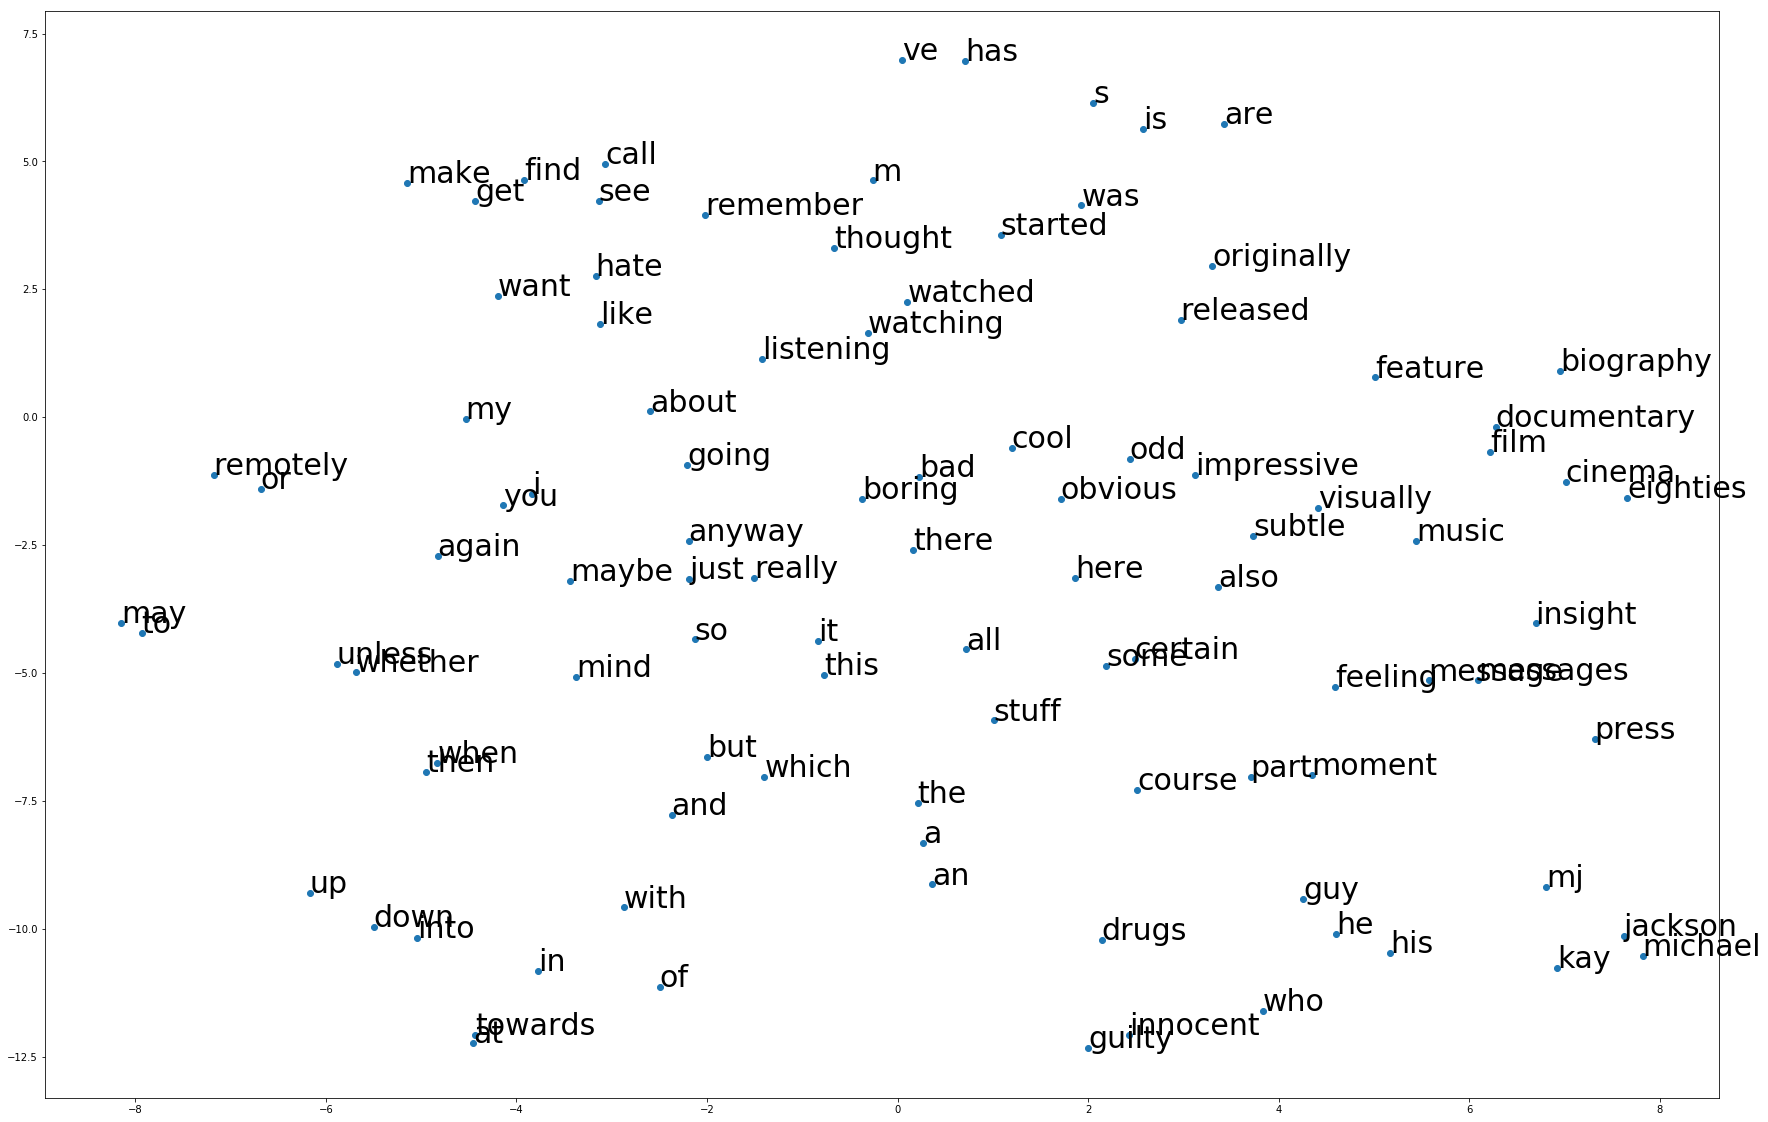

In [19]:
fig = plt.figure()
fig.set_size_inches(30,20)

ax = fig.add_subplot(1,1,1)
ax.scatter(df['X'], df['Y'])

# Put the label on each point.
for word, pos in df.iterrows():
    ax.annotate(word, pos, fontsize = 30)
plt.show()

The above plot indicates a lot of information about the movie. First, some groups consist of very similar words. "michael", "jackson" and "mj" are located very closely and "his", "he", and "guy" are also very close to each other or "bad" and "boring". On the other hand, some words are grouped with totally opposite words such as "innocent" and "guilty" or "want" and "hate". From this fact, without even reading the actual reviews, we can presume that many positive reviews came from Michael Jackson fans and many negative reviews came from non-Micael Jackson fans because as mentioned above, the totally opposite meaning of words are clustered very closely like "hate" and "like".<br> 

We can find some very informative words describing the movie including "eighties", "music", "documentary", "biography", "remember", "unless". By these words, we can easily infer that the first review is about Michael Jackson biographical documentary. Also, this move would be bad or boring unless you are a fan of Michael Jackson.<br>

Lastly, one more pattern to notice is stopword groups: "the", "a", "an" and "is", "was", "are", "s", "ve", "has". Even though they do not give any information about the review, the fact that the stopwords are clustered together closely shows how well the t-sne performed.<br>

Compared to the previous methods' (CountVectorizer, TF-IDF) WordCloud, it appears more informative and based on the above plot, we can capture the general shape of the first review.

## 6. From Words to Paragraph <a id='fwp'></a>

### 6.1 Vector Averaging <a id='vaveraging'></a>

In [20]:
''' 

The purpose of this function is to combine all the word2vec vector values of each word in each review
if each review is given as input and divide by the total number of words.

Each word can be represented as number of feature dimension space vector. ex) model['flower'] = array([0.1, 0.2, ...]).
(You can think of it as extended xy coordinate.) Therefore, it enables vectorizing each review by 
combining all the words' vector values.

Illustration example:

'I' = [0.1, 0.2, ...]
'have' = [0.2, 0.3, ...]
'a car' = [0.1, 0.2, ...]
'I have a car' = [0.1 + 0.2 + 0.1, 0.2 + 0.3 + 0.2,  ...]


ex) review1 = ['he', 'has', 'a', 'cat']

First word : If the word 'he' is in the word2vec, index the vector values from word2vec model by model['he']
(the dimension of the matrix would be, in this case, (400,) ) and add them to predefined zero matrix.

Second word: Check if there is the word 'has' in the word2vec model and if there is, index the vector values and 
add them on top of the added vector values from the first word.

The rest: Iterate the above steps for the rest of words and lastly, divide by the total number of words. 

Illustration example: 

zero : [0,    0,   0,   ....]
word1: [0.2,  0.3, 0.4, ....]
word2: [0.1,  0.2, 0.3, ....]

word(1~2): [0.3, 0.5, 0.7, ....]

'''

def makeFeatureVec(review, model, num_features):
    
    featureVec = np.zeros((num_features,), dtype = "float32")
    
    # Unique word set
    word_index = set(model.wv.index2word)
    
    # For division we need to count the number of words
    nword = 0
    
    # Iterate words in a review and if the word is in the unique wordset, add the vector values for each word.
    for word in review:
        if word in word_index:
            nword += 1
            featureVec = np.add(featureVec, model[word])
    
    # Divide the sum of vector values by total number of word in a review.
    featureVec = np.divide(featureVec, nword)        
    
    return featureVec

In [21]:
''' 

While iterating over reviews, add the vector sums of each review from the function "makeFeatureVec" to 
the predefined vector whose size is the number of total reviews and the number of features in word2vec.
The working principle is basically same with "makeFeatureVec" but this is a review basis and 
makeFeatureVec is word basis (or each word's vector basis)


return matrix:

            'V1'    'V2'    'V3'     'V4'
review 1    0.1      0.2     0.1     0.5
review 2    0.5      0.4     0.05    0.05

'''

def getAvgFeatureVec(clean_reviews, model, num_features):
    
    # Keep track of the sequence of reviews, create the number "th" variable.
    review_th = 0
    
    # Row: number of total reviews, Column: number of vector spaces (num_features = 250 we set this in Word2Vec step).
    reviewFeatureVecs = np.zeros((len(clean_reviews), num_features), dtype = "float32")
    
    # Iterate over reviews and add the result of makeFeatureVec.
    for review in clean_reviews:
        reviewFeatureVecs[int(review_th)] = makeFeatureVec(review, model, num_features)
        
        # Once the vector values are added, increase the one for the review_th variable.
        review_th += 1
    
    return reviewFeatureVecs

In [22]:
clean_train_reviews = []

# Clean the reviews by preprocessing function with stopwords option "on".
for review in train["review"]:
    clean_train_reviews.append(preprocess_wordlist(review, stopwords = True))

# Apply "getAvgFeatureVec" function.
trainDataAvg = getAvgFeatureVec(clean_train_reviews, model, num_features)
    
    
# Same steps repeats as we did for train_set.    
clean_test_reviews = []

for review in test["review"]:
    clean_test_reviews.append(preprocess_wordlist(review, stopwords = True))

testDataAvg = getAvgFeatureVec(clean_test_reviews, model, num_features)

Notice that we use stop word removal, which would just add noise.<br>
We will compare the performance of vector averaging method and the next method. 

### 6.2 Clustering <a id='clustering'></a>

Word2Vec creates clusters of semantically related words, so we can try to use the similarity of words within a cluster. To achieve this, we will be using one of the most commonly used clustering technique called K-Means.

In [23]:
from sklearn.cluster import KMeans
import time

#### 6.2.1 KMeans Clustering <a id='kmc'></a>

In [24]:
print(model.wv.syn0.shape)

(16487, 250)


In [25]:
num_clusters = model.wv.syn0.shape[0] // 5

Based on what I have experimented, small clusters, with an average of only 5 words or so per cluster, gave better results than large clusters with many words. Feel free to change it to improve the score.

In [26]:
start = time.time()

kmean = KMeans(n_clusters = num_clusters)
index = kmean.fit_predict(model.wv.syn0)

end = time.time()
print("Time taken for K-Means clustering: ", end - start, "seconds.")

Time taken for K-Means clustering:  487.3845820426941 seconds.


word2vec's each row represents each word appeared in data after cleaning process. The column represents each variable of vector value. In other word, words * features matrix.

#### 6.2.2 Mapping Vocabulary to Cluster <a id='mvc'></a>

In [27]:
index = list(index)
voca_list = model.wv.index2word

# dictionary format -  word : the cluster where the key word belongs.
voca_cluster = {voca_list[i]: index[i] for i in range(len(voca_list))}

Check whether the clustering model that we created works by printing words belongs to the first ten clusters

In [28]:
# Check the first 10 clusters in voca_cluster we created.

# Loop from 0 to 9th cluster 
for cluster in range(10):
    
    word = []
    
    # Iterate over the number of total words. 
    for i in range(len(voca_cluster.values())):
        
        # If the cluster (0~10) corresponds to iterating i th voca_cluster values (cluster),
        if(list(voca_cluster.values())[i] == cluster):
            
            # Append the words.
            word.append(list(voca_cluster.keys())[i])
    
    print(word)

['gable', 'loy', 'myrna', 'blandings', 'withers']
['mississippi', 'biko', 'apartheid']
['rubbing', 'spilling', 'stuffing', 'shoving']
['jewel', 'abu', 'tobacco', 'sierra', 'journalism', 'commission', 'hoax', 'anderton', 'racket', 'covert', 'investigative', 'bureau', 'ga', 'syndicate', 'tanz']
['knox', 'cunningham', 'finch', 'atwill', 'davidson', 'mcshane', 'bernsen', 'corbin', 'visibly', 'donovan', 'kessler', 'murdoch', 'hoyt', 'feinstone', 'sutton', 'xavier', 'manuel', 'kellogg', 'shanks', 'britt', 'auteuil', 'houseman', 'petulia']
['bodies', 'poison', 'fruit', 'pigs', 'bats', 'worms', 'organs', 'slaughterhouse', 'chambers', 'beans', 'poisonous', 'maggots', 'chickens', 'gunshots', 'freshly', 'cockroaches', 'fingerprints']
['unusual', 'unconventional', 'atypical', 'inconsistency']
['according', 'contributed', 'attributed']
['genre', 'genres', 'styles', 'extremes', 'categories']
['seth', 'brady', 'pepper', 'dane', 'dillon', 'rufus', 'atkins', 'dorff', 'sewell', 'robby', 'lillard', 'dami

#### 6.2.3 Bag of Centroids <a id='boc'></a>

In [29]:
# Preprocess data for input as before

train_review = []

for review in train['review']:
    train_review.append(preprocess_wordlist(review, stopwords= True))

test_review = []

for review in test['review']:
    test_review.append(preprocess_wordlist(review, stopwords = True))

In [30]:
train_centroid = np.zeros((len(train['review']), num_clusters), dtype = 'float32')
test_centroid = np.zeros((len(test['review']), num_clusters), dtype = 'float32')

In [31]:
'''
The array that we are going to create looks like this:

cl1 cl2 cl3 cl4 ....
 3   10  5   30 ...

As usual we will be creating the empty array having the number of clusters dimension space.
While Iterating over words, if there is any word found in the voca_cluster, find the cluster where the word belongs to
and add one to the feature corresponding to the cluster.

( ex) if 'cat' assigned to cluster 10 then add one to 10th feature in the empty array. )  

'''

def create_boc(wordlist, voca_cluster):
    
    # The number of cluster == the maximum number of values in voca_cluster
    boc = np.zeros(max(voca_cluster.values()) + 1, dtype='float32')
    
    # Iterate over words and increase by one to the cluster if any word in the voca_cluster we created
    for word in wordlist:
        if word in voca_cluster:
            index = voca_cluster[word]
            boc[index] += 1
            
    return boc
    

In [32]:
# Transform the training and test set reviews into bags of centroid.

count = 0

for review in train_review:
    train_centroid[count] = create_boc(review, voca_cluster)
    count += 1
    
count = 0

for review in test_review:
    test_centroid[count] = create_boc(review, voca_cluster)
    count += 1
    

In [33]:
print("Train Dimension (avg):",trainDataAvg.shape,",", "Train Dimension (centroid):",train_centroid.shape)

Train Dimension (avg): (25000, 250) , Train Dimension (centroid): (25000, 3297)


## 7. Modeling <a id='modeling'></a>

We will be evaluating below algorithms' cross validation means and errors. 

- Linear Support Vector Machine
- Bernoulli Naive Bayes
- Perceptron
- Logistic Regression

In [34]:
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import GridSearchCV, StratifiedKFold, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.neural_network import MLPClassifier

In [35]:
kfold = StratifiedKFold(n_splits=5, random_state = 2018)

### 7.1 Modeling for Vector Averaging <a id='mva'></a>

#### 7.11 Support Vector Machine <a id='svm1'></a>

In [36]:
# LinearSVC

sv = LinearSVC(random_state=2018)

param_grid1 = {
    'loss':['squared_hinge'],
    'class_weight':[{1:2}],
    'C': [20],
    'penalty':['l2']
}

gs_sv = GridSearchCV(sv, param_grid = [param_grid1], verbose = 1, cv = kfold, n_jobs = 1, scoring = 'roc_auc' )
gs_sv.fit(trainDataAvg, train['sentiment'])
gs_sv_best = gs_sv.best_estimator_
print(gs_sv.best_params_)

# {'C': 20, 'class_weight': {1: 2}, 'loss': 'squared_hinge', 'penalty': 'l2'} - 86.30

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   54.6s finished


{'C': 20, 'class_weight': {1: 2}, 'loss': 'squared_hinge', 'penalty': 'l2'}


In [37]:
y_submission1 = gs_sv.predict(testDataAvg)

In [38]:
print(gs_sv.best_score_)

0.943428928


#### 7.12 Bernoulli Naive Bayes <a id='bnb1'></a>

In [39]:
bnb = BernoulliNB()
gs_bnb = GridSearchCV(bnb, param_grid = {'alpha': [0.002],
                                         'binarize': [0.001]}, verbose = 1, cv = kfold, n_jobs = 1, scoring = 'roc_auc')
gs_bnb.fit(trainDataAvg, train['sentiment'])
gs_bnb_best = gs_bnb.best_estimator_
print(gs_bnb.best_params_)

# {'alpha': 0.002, 'binarize': 0.001} - 68.348

Fitting 5 folds for each of 1 candidates, totalling 5 fits
{'alpha': 0.002, 'binarize': 0.001}


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.4s finished


In [40]:
print(gs_bnb.best_score_)

0.766064656


#### 7.13 Perceptron <a id='perceptron1'></a>

In [41]:
MLP = MLPClassifier(random_state = 2018)

mlp_param_grid = {
    'hidden_layer_sizes':[(10,10)],
    'activation':['tanh'],
    'solver':['adam'],
    'alpha':[0.01],
    'learning_rate':['constant'],
    'max_iter':[1000]
}

gsMLP = GridSearchCV(MLP, param_grid = mlp_param_grid, cv = kfold, scoring = 'roc_auc', n_jobs= 1, verbose = 1)
gsMLP.fit(trainDataAvg,train['sentiment'])
print(gsMLP.best_params_)
mlp_best0 = gsMLP.best_estimator_

# {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (1,), 'learning_rate': 'constant', 'max_iter': 1000, 'solver': 'adam'} - 87.012
# {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (2,), 'learning_rate': 'constant', 'max_iter': 1000, 'solver': 'adam'} - 86.960
# {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (5,), 'learning_rate': 'constant', 'max_iter': 1000, 'solver': 'adam'} - 87.020
# {'activation': 'tanh', 'alpha': 0.009, 'hidden_layer_sizes': (5,), 'learning_rate': 'constant', 'max_iter': 1000, 'solver': 'adam'} - 87.004
# {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (10, 10), 'learning_rate': 'constant', 'max_iter': 1000, 'solver': 'adam'} - 87.108

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   26.8s finished


{'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (10, 10), 'learning_rate': 'constant', 'max_iter': 1000, 'solver': 'adam'}


In [42]:
y_submission3 = gsMLP.predict(testDataAvg)

In [43]:
print(gsMLP.best_score_)

0.943023104


#### 7.14 Logistic Regression <a id='logi1'></a>

In [44]:
lr = LogisticRegression(random_state = 2018)


lr_param2 = {
    'penalty':['l1'],
    'dual':[False],
    'C':[40],
    'class_weight':['balanced'],
    'solver':['saga']
    
}

lr_CV = GridSearchCV(lr, param_grid = [lr_param2], cv = kfold, scoring = 'roc_auc', n_jobs = 1, verbose = 1)
lr_CV.fit(trainDataAvg,train['sentiment'])
print(lr_CV.best_params_)
logi_best = lr_CV.best_estimator_


# {'C': 100, 'class_weight': 'balanced', 'dual': False, 'penalty': 'l1', 'solver': 'saga'} - 87.376
# {'C': 50, 'class_weight': 'balanced', 'dual': False, 'penalty': 'l1', 'solver': 'saga'} - 87.380
# {'C': 40, 'class_weight': 'balanced', 'dual': False, 'penalty': 'l1', 'solver': 'saga'} - 87.424

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   48.6s finished


{'C': 40, 'class_weight': 'balanced', 'dual': False, 'penalty': 'l1', 'solver': 'saga'}


In [45]:
y_submission4 = lr_CV.predict(testDataAvg)

In [46]:
print(lr_CV.best_score_)

0.94359712


### 7.2 Modeling for Clustering <a id='mc'></a>

#### 7.21 Support Vector Machine <a id='svm2'></a>

In [47]:
# LinearSVC

sv = LinearSVC(random_state=2018)

param_grid1 = {
    'loss':['squared_hinge'],
    'class_weight':['balanced'],
    'C': [0.001],
    'penalty':['l2']
}

gs_sv = GridSearchCV(sv, param_grid = [param_grid1], verbose = 1, cv = kfold, n_jobs = 1, scoring = 'roc_auc' )
gs_sv.fit(train_centroid, train['sentiment'])
gs_sv_best = gs_sv.best_estimator_
print(gs_sv.best_params_)

# {'C': 0.001, 'class_weight': 'balanced', 'loss': 'squared_hinge', 'penalty': 'l2'} - 87.256 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   15.7s finished


{'C': 0.001, 'class_weight': 'balanced', 'loss': 'squared_hinge', 'penalty': 'l2'}


In [ ]:
y_submission11 = gs_sv.predict(test_centroid)

In [48]:
print(gs_sv.best_score_)

0.9413656


#### 7.22 Bernoulli Naive Bayes <a id='bnb2'></a>

In [49]:
bnb = BernoulliNB()
gs_bnb = GridSearchCV(bnb, param_grid = {'alpha': [0.01],
                                         'binarize': [0.001]}, verbose = 1, cv = kfold, n_jobs = 1, scoring = 'roc_auc')
gs_bnb.fit(train_centroid, train['sentiment'])
gs_bnb_best = gs_bnb.best_estimator_
print(gs_bnb.best_params_)

# {'alpha': 0.01, 'binarize': 0.001} - 81.87

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   14.9s finished


{'alpha': 0.01, 'binarize': 0.001}


In [50]:
y_submission22 = gs_bnb.predict(test_centroid)

In [51]:
print(gs_bnb.best_score_)

0.901803952


#### 7.23 Perceptron <a id='perceptron2'></a>

In [52]:
MLP = MLPClassifier(random_state = 2018)

mlp_param_grid = {
    'hidden_layer_sizes':[(5,)],
    'activation':['tanh'],
    'solver':['sgd'],
    'alpha':[1],
    'learning_rate':['adaptive'],
    'max_iter':[1000]
}


gsMLP = GridSearchCV(MLP, param_grid = mlp_param_grid, cv = kfold, scoring = 'roc_auc', n_jobs= 1, verbose = 1)
gsMLP.fit(train_centroid, train['sentiment'])
print(gsMLP.best_params_)
mlp_best0 = gsMLP.best_estimator_

# {'activation': 'tanh', 'alpha': 1, 'hidden_layer_sizes': (1,), 'learning_rate': 'adaptive', 'max_iter': 1000, 'solver': 'sgd'} - 87.092
# {'activation': 'tanh', 'alpha': 1, 'hidden_layer_sizes': (5,), 'learning_rate': 'adaptive', 'max_iter': 1000, 'solver': 'sgd'} - 87.068
# {'activation': 'tanh', 'alpha': 1, 'hidden_layer_sizes': (5,), 'learning_rate': 'adaptive', 'max_iter': 1000, 'solver': 'sgd'} - 87.068

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 12.0min finished


{'activation': 'tanh', 'alpha': 1, 'hidden_layer_sizes': (5,), 'learning_rate': 'adaptive', 'max_iter': 1000, 'solver': 'sgd'}


In [53]:
y_submission33 = gsMLP.predict(test_centroid)

In [54]:
print(gsMLP.best_score_)

0.943142304


#### 7.24 Logistic Regression <a id='logi2'></a>

In [55]:
lr = LogisticRegression(random_state = 2018)

lr_param2 = {
    'penalty':['l1'],
    'dual':[False],
    'class_weight':[{1:2}],
    'C': [100],
    'solver':['saga']
    
}

lr_CV = GridSearchCV(lr, param_grid = [lr_param2], cv = kfold, scoring = 'roc_auc', n_jobs = 1, verbose = 1)
lr_CV.fit(train_centroid,train['sentiment'])
print(lr_CV.best_params_)
logi_best = lr_CV.best_estimator_


# {'C': 100, 'class_weight': {1: 2}, 'dual': False, 'penalty': 'l1', 'solver': 'saga'} - 85.968
# {'C': 100, 'class_weight': {1: 2}, 'dual': False, 'penalty': 'l1', 'solver': 'saga'} - 85.968

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  9.9min finished


{'C': 100, 'class_weight': {1: 2}, 'dual': False, 'penalty': 'l1', 'solver': 'saga'}


In [56]:
y_submission44 = lr_CV.predict(test_centroid)

In [57]:
print(lr_CV.best_score_)

0.940076384


## 8. Submission <a id='submission'></a>

In [58]:
result = pd.DataFrame(data = {'id':test['id'], 'sentiment': y_submission4})
result.to_csv('submission_29.csv', index = False, quoting = 3)

## 9. Conclusion <a id='conclusion'></a>

The best result in this notebook is 87.424% performed by Logistic Regression in Vector Averaging. You may wonder why the result of the bag of words method (CountVectorizer/TF-IDF) performs better. The main reason is that while making the average vector and centroid matrices, the order of words were lost, which makes it very similar to the concept of bag of words. You may try Paragraph Vectors instead of Word Vector to fix the problem of word order since the paragraph vector preserves word order information. Another reason is that as mentioned earlier, due to constraint of my laptop's memory and CPU power, using more than 250 features throws a memory error. If your system is sustainable enough, you can improve the result by increasing the number of features or use more complex models such as XG Boost.<br>

Among the all methods that I attempted, the best result is 90.36% performed by Logistic Regression in TF-IDF. As you notice, all the best results come from Logistic Regression and the worst come from Naive Bayes.<br>